In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
batch_size = 128
# num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# === Transforms ===
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# === Load and Split Data ===
full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
trainset, valset = random_split(full_train, [train_size, val_size])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# === Model ===
model = timm.create_model("resnet50", pretrained=False, num_classes=10)
model.to(device)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# === Metrics Storage ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

# === Training ===
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(trainloader, desc=f"Epoch [{epoch}]")

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        loop.set_postfix(loss=total_loss / total, acc=100. * correct / total)

    avg_loss = total_loss / total
    acc = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

# === Evaluation ===
def evaluate(dataloader, name="Val"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / total
    acc = 100. * correct / total

    if name == "Val":
        val_losses.append(avg_loss)
        val_accuracies.append(acc)
    elif name == "Test":
        test_accuracies.append(acc)

    print(f"{name} Accuracy: {acc:.2f}%, Loss: {avg_loss:.4f}")
    return acc

/home/hesmeraldo/miniconda3/envs/rpstn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|████████████████████████████████████████████████████████████| 170498071/170498071 [00:09<00:00, 17447307.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch [0]: 100%|██████████████████████████████████████████████| 352/352 [00:26<00:00, 13.08it/s, acc=25.3, loss=2.49]


Val Accuracy: 37.74%, Loss: 1.6497


Epoch [1]: 100%|██████████████████████████████████████████████| 352/352 [00:12<00:00, 29.23it/s, acc=42.5, loss=1.55]


Val Accuracy: 47.98%, Loss: 1.4173


Epoch [2]: 100%|████████████████████████████████████████████████| 352/352 [00:11<00:00, 30.00it/s, acc=51, loss=1.35]


Val Accuracy: 52.44%, Loss: 1.3059


Epoch [3]: 100%|████████████████████████████████████████████████| 352/352 [00:11<00:00, 29.99it/s, acc=57, loss=1.21]


Val Accuracy: 59.30%, Loss: 1.1544


Epoch [4]: 100%|██████████████████████████████████████████████| 352/352 [00:11<00:00, 29.73it/s, acc=60.8, loss=1.11]


Val Accuracy: 61.06%, Loss: 1.1178


Epoch [5]: 100%|██████████████████████████████████████████████| 352/352 [00:11<00:00, 29.92it/s, acc=64.1, loss=1.03]


Val Accuracy: 60.98%, Loss: 1.0826


Epoch [6]: 100%|█████████████████████████████████████████████| 352/352 [00:11<00:00, 30.81it/s, acc=66.4, loss=0.966]


Val Accuracy: 62.76%, Loss: 1.0849


Epoch [7]: 100%|█████████████████████████████████████████████| 352/352 [00:11<00:00, 30.41it/s, acc=68.1, loss=0.919]


Val Accuracy: 66.48%, Loss: 0.9830


Epoch [8]: 100%|█████████████████████████████████████████████| 352/352 [00:11<00:00, 29.92it/s, acc=69.2, loss=0.893]


Val Accuracy: 66.56%, Loss: 0.9704


Epoch [9]: 100%|█████████████████████████████████████████████| 352/352 [00:12<00:00, 28.97it/s, acc=70.2, loss=0.865]


Val Accuracy: 68.74%, Loss: 0.8899


Epoch [10]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 29.81it/s, acc=70.8, loss=0.847]


Val Accuracy: 59.40%, Loss: 1.2431


Epoch [11]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 31.14it/s, acc=71.5, loss=0.832]


Val Accuracy: 62.54%, Loss: 1.1036


Epoch [12]: 100%|██████████████████████████████████████████████| 352/352 [00:11<00:00, 30.59it/s, acc=72, loss=0.814]


Val Accuracy: 65.54%, Loss: 1.0251


Epoch [13]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 30.10it/s, acc=72.3, loss=0.807]


Val Accuracy: 66.36%, Loss: 0.9999


Epoch [14]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 30.00it/s, acc=73.1, loss=0.787]


Val Accuracy: 70.80%, Loss: 0.8597


Epoch [15]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 29.90it/s, acc=73.2, loss=0.788]


Val Accuracy: 69.42%, Loss: 0.8860


Epoch [16]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 28.56it/s, acc=73.8, loss=0.777]


Val Accuracy: 69.32%, Loss: 0.8834


Epoch [17]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 30.68it/s, acc=73.7, loss=0.769]


Val Accuracy: 70.08%, Loss: 0.8765


Epoch [18]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 29.41it/s, acc=73.9, loss=0.769]


Val Accuracy: 67.78%, Loss: 0.9562


Epoch [19]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 29.08it/s, acc=74.6, loss=0.749]


Val Accuracy: 70.80%, Loss: 0.8698


Epoch [20]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 30.93it/s, acc=74.6, loss=0.742]


Val Accuracy: 67.82%, Loss: 0.9737


Epoch [21]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 29.07it/s, acc=74.8, loss=0.737]


Val Accuracy: 69.06%, Loss: 0.9167


Epoch [22]: 100%|████████████████████████████████████████████| 352/352 [00:10<00:00, 33.35it/s, acc=74.6, loss=0.745]


Val Accuracy: 68.40%, Loss: 0.9570


Epoch [23]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 31.97it/s, acc=74.9, loss=0.732]


Val Accuracy: 66.78%, Loss: 0.9823


Epoch [24]: 100%|████████████████████████████████████████████| 352/352 [00:10<00:00, 32.06it/s, acc=75.3, loss=0.726]


Val Accuracy: 71.60%, Loss: 0.8502


Epoch [25]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 29.55it/s, acc=75.5, loss=0.719]


Val Accuracy: 71.10%, Loss: 0.8463


Epoch [26]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 29.23it/s, acc=75.7, loss=0.717]


Val Accuracy: 72.04%, Loss: 0.8216


Epoch [27]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 28.65it/s, acc=76.2, loss=0.705]


Val Accuracy: 71.58%, Loss: 0.8388


Epoch [28]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.94it/s, acc=76.2, loss=0.702]


Val Accuracy: 72.84%, Loss: 0.7925


Epoch [29]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.97it/s, acc=76.2, loss=0.701]


Val Accuracy: 69.82%, Loss: 0.9060


Epoch [30]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.28it/s, acc=76.3, loss=0.701]


Val Accuracy: 71.74%, Loss: 0.8485


Epoch [31]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.66it/s, acc=76.3, loss=0.696]


Val Accuracy: 68.32%, Loss: 0.9429


Epoch [32]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.38it/s, acc=76.7, loss=0.687]


Val Accuracy: 73.02%, Loss: 0.7992


Epoch [33]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.19it/s, acc=76.5, loss=0.693]


Val Accuracy: 68.16%, Loss: 0.9503


Epoch [34]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.03it/s, acc=76.5, loss=0.687]


Val Accuracy: 74.90%, Loss: 0.7556


Epoch [35]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.74it/s, acc=77.1, loss=0.678]


Val Accuracy: 72.78%, Loss: 0.8072


Epoch [36]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 26.41it/s, acc=77, loss=0.677]


Val Accuracy: 71.74%, Loss: 0.8356


Epoch [37]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.64it/s, acc=77.1, loss=0.672]


Val Accuracy: 65.28%, Loss: 1.1600


Epoch [38]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.69it/s, acc=77.4, loss=0.669]


Val Accuracy: 72.98%, Loss: 0.8090


Epoch [39]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 26.53it/s, acc=77, loss=0.677]


Val Accuracy: 70.38%, Loss: 0.9047


Epoch [40]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.32it/s, acc=77.5, loss=0.665]


Val Accuracy: 75.16%, Loss: 0.7531


Epoch [41]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.44it/s, acc=77.8, loss=0.658]


Val Accuracy: 73.74%, Loss: 0.7891


Epoch [42]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.08it/s, acc=77.3, loss=0.668]


Val Accuracy: 72.12%, Loss: 0.8135


Epoch [43]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.24it/s, acc=77.6, loss=0.659]


Val Accuracy: 73.06%, Loss: 0.7872


Epoch [44]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.39it/s, acc=77.9, loss=0.658]


Val Accuracy: 73.90%, Loss: 0.7760


Epoch [45]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.12it/s, acc=77.8, loss=0.651]


Val Accuracy: 71.36%, Loss: 0.8477


Epoch [46]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.78it/s, acc=78, loss=0.651]


Val Accuracy: 70.22%, Loss: 0.8910


Epoch [47]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.41it/s, acc=78.1, loss=0.645]


Val Accuracy: 73.28%, Loss: 0.7984


Epoch [48]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.64it/s, acc=77.8, loss=0.653]


Val Accuracy: 72.46%, Loss: 0.8217


Epoch [49]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.12it/s, acc=78.3, loss=0.636]


Val Accuracy: 74.32%, Loss: 0.7486


Epoch [50]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.41it/s, acc=78.4, loss=0.634]


Val Accuracy: 71.72%, Loss: 0.8427


Epoch [51]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.01it/s, acc=78.7, loss=0.628]


Val Accuracy: 72.42%, Loss: 0.8345


Epoch [52]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.88it/s, acc=78.8, loss=0.627]


Val Accuracy: 74.96%, Loss: 0.7603


Epoch [53]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.09it/s, acc=78.8, loss=0.618]


Val Accuracy: 72.78%, Loss: 0.7924


Epoch [54]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.89it/s, acc=78.7, loss=0.625]


Val Accuracy: 76.10%, Loss: 0.6988


Epoch [55]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.61it/s, acc=78.8, loss=0.626]


Val Accuracy: 73.04%, Loss: 0.7871


Epoch [56]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.44it/s, acc=78.9, loss=0.62]


Val Accuracy: 73.12%, Loss: 0.7687


Epoch [57]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.26it/s, acc=78.9, loss=0.624]


Val Accuracy: 74.64%, Loss: 0.7866


Epoch [58]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.54it/s, acc=79.3, loss=0.612]


Val Accuracy: 73.72%, Loss: 0.7641


Epoch [59]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.94it/s, acc=79.1, loss=0.61]


Val Accuracy: 76.14%, Loss: 0.7209


Epoch [60]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.37it/s, acc=79.5, loss=0.606]


Val Accuracy: 72.34%, Loss: 0.8181


Epoch [61]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.76it/s, acc=79.4, loss=0.608]


Val Accuracy: 76.98%, Loss: 0.6865


Epoch [62]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.31it/s, acc=79.9, loss=0.593]


Val Accuracy: 73.94%, Loss: 0.7842


Epoch [63]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.71it/s, acc=79.7, loss=0.596]


Val Accuracy: 75.82%, Loss: 0.7209


Epoch [64]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.08it/s, acc=79.6, loss=0.595]


Val Accuracy: 72.38%, Loss: 0.8467


Epoch [65]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.89it/s, acc=79.8, loss=0.597]


Val Accuracy: 73.56%, Loss: 0.8005


Epoch [66]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 25.57it/s, acc=80, loss=0.589]


Val Accuracy: 73.04%, Loss: 0.8029


Epoch [67]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 25.01it/s, acc=80, loss=0.588]


Val Accuracy: 74.76%, Loss: 0.7246


Epoch [68]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.25it/s, acc=79.9, loss=0.59]


Val Accuracy: 72.50%, Loss: 0.8301


Epoch [69]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.04it/s, acc=80.6, loss=0.573]


Val Accuracy: 73.56%, Loss: 0.8213


Epoch [70]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.98it/s, acc=80.3, loss=0.578]


Val Accuracy: 77.56%, Loss: 0.6686


Epoch [71]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.77it/s, acc=80.3, loss=0.583]


Val Accuracy: 76.26%, Loss: 0.6911


Epoch [72]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.30it/s, acc=80.8, loss=0.566]


Val Accuracy: 76.74%, Loss: 0.7027


Epoch [73]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.18it/s, acc=81.1, loss=0.563]


Val Accuracy: 75.24%, Loss: 0.7500


Epoch [74]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.35it/s, acc=80.4, loss=0.577]


Val Accuracy: 76.68%, Loss: 0.6888


Epoch [75]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.35it/s, acc=80.9, loss=0.562]


Val Accuracy: 75.06%, Loss: 0.7453


Epoch [76]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.92it/s, acc=80.8, loss=0.566]


Val Accuracy: 78.18%, Loss: 0.6413


Epoch [77]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.92it/s, acc=81.2, loss=0.56]


Val Accuracy: 74.62%, Loss: 0.7536


Epoch [78]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.76it/s, acc=81.5, loss=0.549]


Val Accuracy: 75.14%, Loss: 0.7603


Epoch [79]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.13it/s, acc=81.6, loss=0.54]


Val Accuracy: 73.34%, Loss: 0.7896


Epoch [80]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.92it/s, acc=81.4, loss=0.547]


Val Accuracy: 78.04%, Loss: 0.6692


Epoch [81]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.64it/s, acc=81.5, loss=0.547]


Val Accuracy: 72.36%, Loss: 0.8588


Epoch [82]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.54it/s, acc=81.7, loss=0.542]


Val Accuracy: 77.00%, Loss: 0.6889


Epoch [83]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.92it/s, acc=81.9, loss=0.538]


Val Accuracy: 78.44%, Loss: 0.6518


Epoch [84]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.80it/s, acc=81.9, loss=0.536]


Val Accuracy: 78.62%, Loss: 0.6388


Epoch [85]: 100%|█████████████████████████████████████████████| 352/352 [00:11<00:00, 31.33it/s, acc=81.9, loss=0.53]


Val Accuracy: 78.08%, Loss: 0.6560


Epoch [86]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 26.56it/s, acc=82, loss=0.531]


Val Accuracy: 77.74%, Loss: 0.6618


Epoch [87]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.91it/s, acc=82.4, loss=0.52]


Val Accuracy: 77.66%, Loss: 0.6810


Epoch [88]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.73it/s, acc=82.3, loss=0.518]


Val Accuracy: 77.58%, Loss: 0.6725


Epoch [89]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.75it/s, acc=82.4, loss=0.52]


Val Accuracy: 76.22%, Loss: 0.7269


Epoch [90]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.55it/s, acc=82.6, loss=0.508]


Val Accuracy: 77.96%, Loss: 0.6589


Epoch [91]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.35it/s, acc=82.9, loss=0.506]


Val Accuracy: 77.80%, Loss: 0.6698


Epoch [92]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.25it/s, acc=82.7, loss=0.508]


Val Accuracy: 79.80%, Loss: 0.5918


Epoch [93]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.46it/s, acc=83.1, loss=0.498]


Val Accuracy: 78.58%, Loss: 0.6456


Epoch [94]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 26.26it/s, acc=83, loss=0.497]


Val Accuracy: 77.24%, Loss: 0.6791


Epoch [95]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.45it/s, acc=83.1, loss=0.496]


Val Accuracy: 79.92%, Loss: 0.5954


Epoch [96]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.47it/s, acc=83.3, loss=0.487]


Val Accuracy: 78.42%, Loss: 0.6476


Epoch [97]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.35it/s, acc=83.4, loss=0.489]


Val Accuracy: 76.04%, Loss: 0.7227


Epoch [98]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 27.81it/s, acc=83.6, loss=0.478]


Val Accuracy: 78.86%, Loss: 0.6391


Epoch [99]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.78it/s, acc=83.4, loss=0.487]


Val Accuracy: 79.18%, Loss: 0.6116


Epoch [100]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.70it/s, acc=83.8, loss=0.473]


Val Accuracy: 81.38%, Loss: 0.5420


Epoch [101]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.29it/s, acc=84.1, loss=0.466]


Val Accuracy: 79.32%, Loss: 0.6227


Epoch [102]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 26.73it/s, acc=84, loss=0.47]


Val Accuracy: 80.22%, Loss: 0.5865


Epoch [103]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.08it/s, acc=84.1, loss=0.465]


Val Accuracy: 82.08%, Loss: 0.5277


Epoch [104]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.03it/s, acc=84.7, loss=0.452]


Val Accuracy: 77.60%, Loss: 0.6948


Epoch [105]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.53it/s, acc=84.7, loss=0.454]


Val Accuracy: 79.90%, Loss: 0.6111


Epoch [106]: 100%|████████████████████████████████████████████| 352/352 [00:12<00:00, 27.27it/s, acc=84.7, loss=0.45]


Val Accuracy: 79.52%, Loss: 0.6172


Epoch [107]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.82it/s, acc=84.9, loss=0.439]


Val Accuracy: 80.70%, Loss: 0.5682


Epoch [108]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 27.04it/s, acc=84.9, loss=0.439]


Val Accuracy: 79.82%, Loss: 0.6161


Epoch [109]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.96it/s, acc=85.2, loss=0.437]


Val Accuracy: 79.38%, Loss: 0.6024


Epoch [110]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.37it/s, acc=85.4, loss=0.432]


Val Accuracy: 80.10%, Loss: 0.6035


Epoch [111]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.41it/s, acc=85.6, loss=0.424]


Val Accuracy: 80.92%, Loss: 0.5617


Epoch [112]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.32it/s, acc=85.7, loss=0.423]


Val Accuracy: 81.32%, Loss: 0.5619


Epoch [113]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.43it/s, acc=85.5, loss=0.423]


Val Accuracy: 81.40%, Loss: 0.5668


Epoch [114]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.18it/s, acc=86, loss=0.413]


Val Accuracy: 81.30%, Loss: 0.5613


Epoch [115]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.48it/s, acc=86.1, loss=0.404]


Val Accuracy: 79.98%, Loss: 0.5943


Epoch [116]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.73it/s, acc=86.1, loss=0.405]


Val Accuracy: 82.56%, Loss: 0.5111


Epoch [117]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.68it/s, acc=86.4, loss=0.4]


Val Accuracy: 82.32%, Loss: 0.5528


Epoch [118]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.15it/s, acc=86.6, loss=0.391]


Val Accuracy: 79.02%, Loss: 0.6350


Epoch [119]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.54it/s, acc=86.6, loss=0.394]


Val Accuracy: 80.96%, Loss: 0.5842


Epoch [120]: 100%|███████████████████████████████████████████| 352/352 [00:14<00:00, 25.12it/s, acc=86.9, loss=0.383]


Val Accuracy: 80.10%, Loss: 0.5859


Epoch [121]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.31it/s, acc=87, loss=0.381]


Val Accuracy: 82.98%, Loss: 0.5094


Epoch [122]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.52it/s, acc=87, loss=0.377]


Val Accuracy: 83.16%, Loss: 0.5076


Epoch [123]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.29it/s, acc=87.5, loss=0.363]


Val Accuracy: 82.18%, Loss: 0.5337


Epoch [124]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.80it/s, acc=87.5, loss=0.364]


Val Accuracy: 82.48%, Loss: 0.5228


Epoch [125]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.20it/s, acc=87.7, loss=0.363]


Val Accuracy: 81.42%, Loss: 0.5578


Epoch [126]: 100%|███████████████████████████████████████████| 352/352 [00:14<00:00, 24.91it/s, acc=87.9, loss=0.355]


Val Accuracy: 81.06%, Loss: 0.5630


Epoch [127]: 100%|███████████████████████████████████████████| 352/352 [00:14<00:00, 24.97it/s, acc=87.9, loss=0.351]


Val Accuracy: 82.74%, Loss: 0.5181


Epoch [128]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.31it/s, acc=88.1, loss=0.344]


Val Accuracy: 82.64%, Loss: 0.5459


Epoch [129]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.22it/s, acc=88.4, loss=0.339]


Val Accuracy: 81.92%, Loss: 0.5420


Epoch [130]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.27it/s, acc=88.5, loss=0.335]


Val Accuracy: 82.90%, Loss: 0.5329


Epoch [131]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.26it/s, acc=88.7, loss=0.329]


Val Accuracy: 83.58%, Loss: 0.5021


Epoch [132]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.09it/s, acc=89.1, loss=0.322]


Val Accuracy: 83.34%, Loss: 0.4931


Epoch [133]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.96it/s, acc=89, loss=0.319]


Val Accuracy: 81.60%, Loss: 0.5615


Epoch [134]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.58it/s, acc=89.2, loss=0.311]


Val Accuracy: 84.10%, Loss: 0.4876


Epoch [135]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.63it/s, acc=89.6, loss=0.3]


Val Accuracy: 83.78%, Loss: 0.4889


Epoch [136]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.00it/s, acc=89.6, loss=0.304]


Val Accuracy: 83.72%, Loss: 0.5069


Epoch [137]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.66it/s, acc=90, loss=0.288]


Val Accuracy: 84.42%, Loss: 0.4749


Epoch [138]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.07it/s, acc=90.1, loss=0.286]


Val Accuracy: 83.78%, Loss: 0.4997


Epoch [139]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.28it/s, acc=90.2, loss=0.283]


Val Accuracy: 83.82%, Loss: 0.5092


Epoch [140]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.21it/s, acc=90.3, loss=0.28]


Val Accuracy: 84.54%, Loss: 0.4909


Epoch [141]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.16it/s, acc=90.8, loss=0.266]


Val Accuracy: 84.10%, Loss: 0.5037


Epoch [142]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.43it/s, acc=90.6, loss=0.268]


Val Accuracy: 83.30%, Loss: 0.5293


Epoch [143]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.27it/s, acc=91.3, loss=0.255]


Val Accuracy: 84.90%, Loss: 0.4717


Epoch [144]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.42it/s, acc=91.5, loss=0.246]


Val Accuracy: 85.04%, Loss: 0.4799


Epoch [145]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.63it/s, acc=91.7, loss=0.242]


Val Accuracy: 84.72%, Loss: 0.4808


Epoch [146]: 100%|████████████████████████████████████████████| 352/352 [00:11<00:00, 30.65it/s, acc=91.6, loss=0.24]


Val Accuracy: 85.60%, Loss: 0.4532


Epoch [147]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.85it/s, acc=91.9, loss=0.233]


Val Accuracy: 84.04%, Loss: 0.4910


Epoch [148]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 28.32it/s, acc=92.1, loss=0.229]


Val Accuracy: 84.88%, Loss: 0.4634


Epoch [149]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.85it/s, acc=92.4, loss=0.215]


Val Accuracy: 85.90%, Loss: 0.4570


Epoch [150]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.22it/s, acc=92.6, loss=0.213]


Val Accuracy: 85.36%, Loss: 0.4715


Epoch [151]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.39it/s, acc=93, loss=0.201]


Val Accuracy: 84.84%, Loss: 0.4937


Epoch [152]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.54it/s, acc=92.9, loss=0.205]


Val Accuracy: 85.16%, Loss: 0.4797


Epoch [153]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.43it/s, acc=93.4, loss=0.194]


Val Accuracy: 86.30%, Loss: 0.4368


Epoch [154]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 28.37it/s, acc=93.8, loss=0.183]


Val Accuracy: 86.22%, Loss: 0.4546


Epoch [155]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.48it/s, acc=94.1, loss=0.173]


Val Accuracy: 86.78%, Loss: 0.4449


Epoch [156]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.81it/s, acc=94, loss=0.174]


Val Accuracy: 85.82%, Loss: 0.4520


Epoch [157]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.61it/s, acc=94.4, loss=0.163]


Val Accuracy: 86.36%, Loss: 0.4482


Epoch [158]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.62it/s, acc=94.5, loss=0.161]


Val Accuracy: 86.32%, Loss: 0.4450


Epoch [159]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.73it/s, acc=94.7, loss=0.152]


Val Accuracy: 86.14%, Loss: 0.4612


Epoch [160]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.16it/s, acc=95.1, loss=0.145]


Val Accuracy: 86.98%, Loss: 0.4396


Epoch [161]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 27.65it/s, acc=95.4, loss=0.136]


Val Accuracy: 86.74%, Loss: 0.4529


Epoch [162]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.14it/s, acc=95.3, loss=0.133]


Val Accuracy: 86.50%, Loss: 0.4447


Epoch [163]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.87it/s, acc=95.5, loss=0.127]


Val Accuracy: 86.92%, Loss: 0.4349


Epoch [164]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 25.99it/s, acc=96, loss=0.115]


Val Accuracy: 87.04%, Loss: 0.4613


Epoch [165]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.34it/s, acc=96.1, loss=0.113]


Val Accuracy: 87.58%, Loss: 0.4402


Epoch [166]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.60it/s, acc=96.4, loss=0.103]


Val Accuracy: 87.28%, Loss: 0.4513


Epoch [167]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 29.30it/s, acc=96.7, loss=0.0954]


Val Accuracy: 86.28%, Loss: 0.4923


Epoch [168]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.95it/s, acc=97, loss=0.0884]


Val Accuracy: 87.38%, Loss: 0.4615


Epoch [169]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 27.02it/s, acc=97, loss=0.0855]


Val Accuracy: 87.72%, Loss: 0.4587


Epoch [170]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.72it/s, acc=97.2, loss=0.0822]


Val Accuracy: 87.76%, Loss: 0.4524


Epoch [171]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.05it/s, acc=97.6, loss=0.0703]


Val Accuracy: 87.66%, Loss: 0.4646


Epoch [172]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.20it/s, acc=97.6, loss=0.0706]


Val Accuracy: 88.90%, Loss: 0.4164


Epoch [173]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.68it/s, acc=97.8, loss=0.0663]


Val Accuracy: 87.06%, Loss: 0.4810


Epoch [174]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.85it/s, acc=98, loss=0.0598]


Val Accuracy: 88.10%, Loss: 0.4479


Epoch [175]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.72it/s, acc=98.2, loss=0.0527]


Val Accuracy: 87.54%, Loss: 0.4800


Epoch [176]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.37it/s, acc=98.4, loss=0.0479]


Val Accuracy: 89.06%, Loss: 0.4256


Epoch [177]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.46it/s, acc=98.6, loss=0.0429]


Val Accuracy: 88.56%, Loss: 0.4401


Epoch [178]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.78it/s, acc=98.7, loss=0.0417]


Val Accuracy: 88.46%, Loss: 0.4720


Epoch [179]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.58it/s, acc=98.7, loss=0.0392]


Val Accuracy: 89.14%, Loss: 0.4414


Epoch [180]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.09it/s, acc=98.9, loss=0.0333]


Val Accuracy: 88.34%, Loss: 0.4671


Epoch [181]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.98it/s, acc=99.1, loss=0.027]


Val Accuracy: 88.82%, Loss: 0.4573


Epoch [182]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 26.98it/s, acc=99.1, loss=0.026]


Val Accuracy: 88.98%, Loss: 0.4711


Epoch [183]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.95it/s, acc=99.2, loss=0.0246]


Val Accuracy: 88.50%, Loss: 0.4535


Epoch [184]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.54it/s, acc=99.3, loss=0.0224]


Val Accuracy: 89.48%, Loss: 0.4443


Epoch [185]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.41it/s, acc=99.4, loss=0.0188]


Val Accuracy: 89.66%, Loss: 0.4587


Epoch [186]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 27.06it/s, acc=99.4, loss=0.0184]


Val Accuracy: 88.78%, Loss: 0.4656


Epoch [187]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.22it/s, acc=99.5, loss=0.0169]


Val Accuracy: 89.88%, Loss: 0.4434


Epoch [188]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.29it/s, acc=99.6, loss=0.0138]


Val Accuracy: 89.56%, Loss: 0.4574


Epoch [189]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.39it/s, acc=99.5, loss=0.0159]


Val Accuracy: 89.58%, Loss: 0.4441


Epoch [190]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 28.02it/s, acc=99.6, loss=0.013]


Val Accuracy: 89.78%, Loss: 0.4282


Epoch [191]: 100%|██████████████████████████████████████████| 352/352 [00:13<00:00, 26.98it/s, acc=99.6, loss=0.0122]


Val Accuracy: 89.96%, Loss: 0.4467


Epoch [192]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.78it/s, acc=99.7, loss=0.0118]


Val Accuracy: 89.86%, Loss: 0.4526


Epoch [193]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.30it/s, acc=99.7, loss=0.0118]


Val Accuracy: 89.50%, Loss: 0.4455


Epoch [194]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.47it/s, acc=99.7, loss=0.0108]


Val Accuracy: 89.66%, Loss: 0.4534


Epoch [195]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.15it/s, acc=99.7, loss=0.0117]


Val Accuracy: 89.92%, Loss: 0.4419


Epoch [196]: 100%|███████████████████████████████████████████| 352/352 [00:12<00:00, 28.11it/s, acc=99.7, loss=0.011]


Val Accuracy: 89.86%, Loss: 0.4354


Epoch [197]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 28.42it/s, acc=99.7, loss=0.0121]


Val Accuracy: 89.84%, Loss: 0.4471


Epoch [198]: 100%|██████████████████████████████████████████| 352/352 [00:11<00:00, 29.65it/s, acc=99.7, loss=0.0115]


Val Accuracy: 90.10%, Loss: 0.4442


Epoch [199]: 100%|██████████████████████████████████████████| 352/352 [00:12<00:00, 27.96it/s, acc=99.7, loss=0.0104]


Val Accuracy: 89.68%, Loss: 0.4611
Test Accuracy: 89.91%, Loss: 0.4328


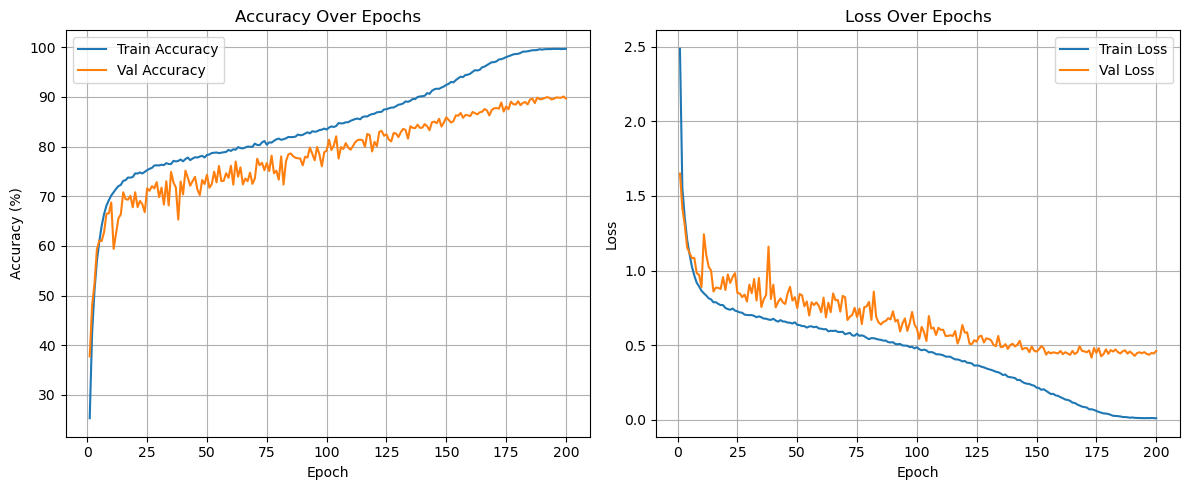


Best Val Accuracy: 90.10%
Final Test Accuracy: 89.91%


In [ ]:
# === Training Loop ===
num_epochs = 400
best_acc = 0
for epoch in range(num_epochs):
    train(epoch)
    val_acc = evaluate(valloader, name="Val")
    scheduler.step()

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_cifar10_training2.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with test accuracy: {best_acc:.4f}")

# === Final Test Accuracy ===
final_test_acc = evaluate(testloader, name="Test")

# === Plotting ===
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

print(f"\nBest Val Accuracy: {best_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

## train again

#### 10 more epochs

In [1]:
# === Training Loop ===
num_epochs = 10
best_acc = 0
for epoch in range(num_epochs):
    train(epoch)
    val_acc = evaluate(valloader, name="Val")
    scheduler.step()

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_cifar10_training2.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with test accuracy: {best_acc:.4f}")

# === Final Test Accuracy ===
final_test_acc = evaluate(testloader, name="Test")

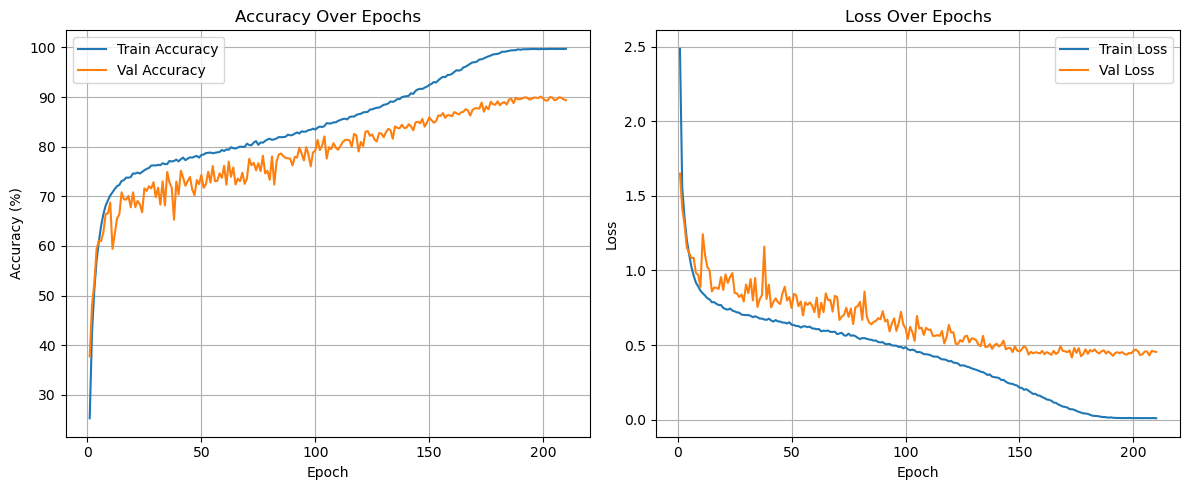


Best Val Accuracy: 90.00%
Final Test Accuracy: 89.90%


In [ ]:
# === Plotting ===
epochs = np.arange(1, 210 + 1)
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

print(f"\nBest Val Accuracy: {best_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

#### 100 more epochs

In [ ]:
# === Training Loop ===
num_epochs = 100
best_acc = 0  # should not have done this!
for epoch in range(num_epochs):
    train(epoch)
    val_acc = evaluate(valloader, name="Val")
    scheduler.step()

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_cifar10_training2.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with test accuracy: {best_acc:.4f}")

# === Final Test Accuracy ===
final_test_acc = evaluate(testloader, name="Test")

Epoch [0]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.81it/s, acc=99.7, loss=0.0102]


Val Accuracy: 89.08%, Loss: 0.4845
✅ Best model saved at epoch 1 with test accuracy: 89.0800


Epoch [1]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.74it/s, acc=99.6, loss=0.0122]


Val Accuracy: 89.06%, Loss: 0.4789


Epoch [2]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.08it/s, acc=99.6, loss=0.0123]


Val Accuracy: 89.44%, Loss: 0.4772
✅ Best model saved at epoch 3 with test accuracy: 89.4400


Epoch [3]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 26.66it/s, acc=99.7, loss=0.0111]


Val Accuracy: 89.36%, Loss: 0.4719


Epoch [4]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.41it/s, acc=99.7, loss=0.0114]


Val Accuracy: 89.56%, Loss: 0.4746
✅ Best model saved at epoch 5 with test accuracy: 89.5600


Epoch [5]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.43it/s, acc=99.6, loss=0.0123]


Val Accuracy: 89.44%, Loss: 0.4888


Epoch [6]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.24it/s, acc=99.6, loss=0.0138]


Val Accuracy: 89.20%, Loss: 0.4943


Epoch [7]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.67it/s, acc=99.5, loss=0.0167]


Val Accuracy: 89.20%, Loss: 0.4949


Epoch [8]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.49it/s, acc=99.5, loss=0.0175]


Val Accuracy: 88.66%, Loss: 0.4877


Epoch [9]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.09it/s, acc=99.3, loss=0.0218]


Val Accuracy: 88.68%, Loss: 0.5027


Epoch [10]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.51it/s, acc=99.2, loss=0.0235]


Val Accuracy: 88.56%, Loss: 0.5039


Epoch [11]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.24it/s, acc=99.1, loss=0.0281]


Val Accuracy: 88.06%, Loss: 0.5145


Epoch [12]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.34it/s, acc=98.6, loss=0.0396]


Val Accuracy: 87.66%, Loss: 0.5111


Epoch [13]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.28it/s, acc=98.7, loss=0.0394]


Val Accuracy: 88.44%, Loss: 0.4889


Epoch [14]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.28it/s, acc=98.4, loss=0.0471]


Val Accuracy: 87.88%, Loss: 0.4970


Epoch [15]: 100%|█████████████████████████████████████████████| 352/352 [00:13<00:00, 26.05it/s, acc=98, loss=0.0556]


Val Accuracy: 87.14%, Loss: 0.5161


Epoch [16]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.43it/s, acc=97.9, loss=0.0612]


Val Accuracy: 87.76%, Loss: 0.4791


Epoch [17]: 100%|███████████████████████████████████████████| 352/352 [00:13<00:00, 25.26it/s, acc=97.8, loss=0.0652]


Val Accuracy: 87.26%, Loss: 0.5145


Epoch [18]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.42it/s, acc=97.5, loss=0.075]


Val Accuracy: 86.88%, Loss: 0.5072


Epoch [19]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 25.08it/s, acc=97, loss=0.086]


Val Accuracy: 87.34%, Loss: 0.4665


Epoch [20]: 100%|███████████████████████████████████████████| 352/352 [00:14<00:00, 24.70it/s, acc=96.7, loss=0.0945]


Val Accuracy: 87.12%, Loss: 0.4736


Epoch [21]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.07it/s, acc=96.3, loss=0.107]


Val Accuracy: 86.00%, Loss: 0.5004


Epoch [22]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.01it/s, acc=96.1, loss=0.112]


Val Accuracy: 86.10%, Loss: 0.4937


Epoch [23]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.68it/s, acc=95.8, loss=0.121]


Val Accuracy: 86.38%, Loss: 0.4906


Epoch [24]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.54it/s, acc=95.6, loss=0.126]


Val Accuracy: 86.12%, Loss: 0.4840


Epoch [25]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.86it/s, acc=95, loss=0.145]


Val Accuracy: 85.30%, Loss: 0.5012


Epoch [26]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.78it/s, acc=94.9, loss=0.149]


Val Accuracy: 85.48%, Loss: 0.4943


Epoch [27]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.49it/s, acc=94.7, loss=0.158]


Val Accuracy: 85.48%, Loss: 0.4923


Epoch [28]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.19it/s, acc=94.3, loss=0.166]


Val Accuracy: 84.92%, Loss: 0.5056


Epoch [29]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.76it/s, acc=94.4, loss=0.164]


Val Accuracy: 84.76%, Loss: 0.5264


Epoch [30]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.03it/s, acc=93.6, loss=0.185]


Val Accuracy: 85.32%, Loss: 0.4851


Epoch [31]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.94it/s, acc=93.4, loss=0.188]


Val Accuracy: 84.04%, Loss: 0.5284


Epoch [32]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.93it/s, acc=93.2, loss=0.198]


Val Accuracy: 84.86%, Loss: 0.5233


Epoch [33]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.77it/s, acc=93.1, loss=0.202]


Val Accuracy: 85.12%, Loss: 0.4907


Epoch [34]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.82it/s, acc=92.7, loss=0.21]


Val Accuracy: 83.10%, Loss: 0.5454


Epoch [35]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=92.4, loss=0.22]


Val Accuracy: 84.54%, Loss: 0.5146


Epoch [36]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.79it/s, acc=92.3, loss=0.221]


Val Accuracy: 84.48%, Loss: 0.5133


Epoch [37]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.74it/s, acc=92, loss=0.228]


Val Accuracy: 84.34%, Loss: 0.5160


Epoch [38]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=91.9, loss=0.234]


Val Accuracy: 83.64%, Loss: 0.5153


Epoch [39]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.99it/s, acc=92, loss=0.231]


Val Accuracy: 82.82%, Loss: 0.5536


Epoch [40]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.66it/s, acc=91.6, loss=0.24]


Val Accuracy: 82.70%, Loss: 0.5558


Epoch [41]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=91.6, loss=0.241]


Val Accuracy: 85.12%, Loss: 0.4937


Epoch [42]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=91.6, loss=0.243]


Val Accuracy: 82.98%, Loss: 0.5572


Epoch [43]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.18it/s, acc=91.5, loss=0.248]


Val Accuracy: 81.98%, Loss: 0.5628


Epoch [44]: 100%|███████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=91, loss=0.26]


Val Accuracy: 82.94%, Loss: 0.5527


Epoch [45]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.99it/s, acc=91.1, loss=0.26]


Val Accuracy: 83.74%, Loss: 0.5186


Epoch [46]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.23it/s, acc=91.1, loss=0.259]


Val Accuracy: 84.00%, Loss: 0.5082


Epoch [47]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.68it/s, acc=90.8, loss=0.268]


Val Accuracy: 80.62%, Loss: 0.6157


Epoch [48]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.18it/s, acc=90.6, loss=0.271]


Val Accuracy: 81.68%, Loss: 0.5770


Epoch [49]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.74it/s, acc=90.8, loss=0.268]


Val Accuracy: 84.38%, Loss: 0.4994


Epoch [50]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.60it/s, acc=90.2, loss=0.285]


Val Accuracy: 83.34%, Loss: 0.5297


Epoch [51]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.64it/s, acc=90.6, loss=0.273]


Val Accuracy: 82.42%, Loss: 0.5493


Epoch [52]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.26it/s, acc=90.3, loss=0.281]


Val Accuracy: 82.70%, Loss: 0.5458


Epoch [53]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.16it/s, acc=90.1, loss=0.291]


Val Accuracy: 81.04%, Loss: 0.6054


Epoch [54]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.19it/s, acc=89.8, loss=0.293]


Val Accuracy: 83.50%, Loss: 0.5076


Epoch [55]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 25.51it/s, acc=89.7, loss=0.3]


Val Accuracy: 82.58%, Loss: 0.5509


Epoch [56]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.12it/s, acc=89.6, loss=0.301]


Val Accuracy: 82.88%, Loss: 0.5236


Epoch [57]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.75it/s, acc=89.5, loss=0.306]


Val Accuracy: 83.78%, Loss: 0.4994


Epoch [58]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.81it/s, acc=89.6, loss=0.305]


Val Accuracy: 83.48%, Loss: 0.5112


Epoch [59]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.21it/s, acc=88.9, loss=0.317]


Val Accuracy: 82.24%, Loss: 0.5443


Epoch [60]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.30it/s, acc=89.2, loss=0.314]


Val Accuracy: 83.48%, Loss: 0.5085


Epoch [61]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.86it/s, acc=88.9, loss=0.322]


Val Accuracy: 82.96%, Loss: 0.5321


Epoch [62]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.95it/s, acc=89, loss=0.318]


Val Accuracy: 81.70%, Loss: 0.5831


Epoch [63]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.70it/s, acc=89, loss=0.324]


Val Accuracy: 82.48%, Loss: 0.5345


Epoch [64]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.91it/s, acc=88.6, loss=0.331]


Val Accuracy: 82.36%, Loss: 0.5608


Epoch [65]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.75it/s, acc=88.5, loss=0.333]


Val Accuracy: 83.04%, Loss: 0.5174


Epoch [66]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.46it/s, acc=88.5, loss=0.335]


Val Accuracy: 82.62%, Loss: 0.5425


Epoch [67]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.63it/s, acc=88.5, loss=0.335]


Val Accuracy: 80.56%, Loss: 0.6037


Epoch [68]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.84it/s, acc=88.4, loss=0.34]


Val Accuracy: 80.30%, Loss: 0.6452


Epoch [69]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.36it/s, acc=87.9, loss=0.352]


Val Accuracy: 82.10%, Loss: 0.5411


Epoch [70]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 25.48it/s, acc=88, loss=0.354]


Val Accuracy: 82.56%, Loss: 0.5253


Epoch [71]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=87.7, loss=0.358]


Val Accuracy: 81.92%, Loss: 0.5465


Epoch [72]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.16it/s, acc=87.6, loss=0.361]


Val Accuracy: 82.08%, Loss: 0.5515


Epoch [73]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.98it/s, acc=87.5, loss=0.367]


Val Accuracy: 80.72%, Loss: 0.6061


Epoch [74]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 25.05it/s, acc=87.4, loss=0.366]


Val Accuracy: 81.22%, Loss: 0.5664


Epoch [75]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.35it/s, acc=87.3, loss=0.368]


Val Accuracy: 82.08%, Loss: 0.5488


Epoch [76]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.46it/s, acc=87.1, loss=0.376]


Val Accuracy: 82.56%, Loss: 0.5219


Epoch [77]: 100%|█████████████████████████████████████████████| 352/352 [00:14<00:00, 24.73it/s, acc=87.2, loss=0.38]


Val Accuracy: 80.52%, Loss: 0.6072


Epoch [78]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.43it/s, acc=86.9, loss=0.384]


Val Accuracy: 78.40%, Loss: 0.6861


Epoch [79]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.60it/s, acc=86.6, loss=0.393]


Val Accuracy: 81.04%, Loss: 0.6105


Epoch [80]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.99it/s, acc=86.7, loss=0.389]


Val Accuracy: 82.84%, Loss: 0.5281


Epoch [81]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.41it/s, acc=86.5, loss=0.394]


Val Accuracy: 79.78%, Loss: 0.6235


Epoch [82]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.96it/s, acc=86, loss=0.408]


Val Accuracy: 80.38%, Loss: 0.6104


Epoch [83]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.90it/s, acc=86.1, loss=0.405]


Val Accuracy: 79.88%, Loss: 0.5971


Epoch [84]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.18it/s, acc=86.1, loss=0.405]


Val Accuracy: 82.08%, Loss: 0.5428


Epoch [85]: 100%|██████████████████████████████████████████████| 352/352 [00:13<00:00, 25.51it/s, acc=86, loss=0.408]


Val Accuracy: 78.68%, Loss: 0.6645


Epoch [86]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.96it/s, acc=85.8, loss=0.417]


Val Accuracy: 81.48%, Loss: 0.5684


Epoch [87]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.83it/s, acc=85.5, loss=0.424]


Val Accuracy: 79.64%, Loss: 0.6119


Epoch [88]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.69it/s, acc=85.4, loss=0.428]


Val Accuracy: 79.24%, Loss: 0.6094


Epoch [89]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.96it/s, acc=85.6, loss=0.423]


Val Accuracy: 77.12%, Loss: 0.6752


Epoch [90]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.97it/s, acc=85.4, loss=0.432]


Val Accuracy: 80.30%, Loss: 0.5893


Epoch [91]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.51it/s, acc=85.3, loss=0.433]


Val Accuracy: 80.04%, Loss: 0.6021


Epoch [92]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.35it/s, acc=85.2, loss=0.435]


Val Accuracy: 80.68%, Loss: 0.5734


Epoch [93]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.70it/s, acc=84.9, loss=0.441]


Val Accuracy: 80.72%, Loss: 0.5803


Epoch [94]: 100%|██████████████████████████████████████████████| 352/352 [00:14<00:00, 24.94it/s, acc=85, loss=0.444]


Val Accuracy: 80.16%, Loss: 0.6057


Epoch [95]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.19it/s, acc=85.2, loss=0.444]


Val Accuracy: 78.16%, Loss: 0.6427


Epoch [96]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.72it/s, acc=84.5, loss=0.458]


Val Accuracy: 78.66%, Loss: 0.6228


Epoch [97]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.98it/s, acc=84.7, loss=0.453]


Val Accuracy: 78.16%, Loss: 0.6406


Epoch [98]: 100%|████████████████████████████████████████████| 352/352 [00:14<00:00, 24.92it/s, acc=84.3, loss=0.461]


Val Accuracy: 79.96%, Loss: 0.6370


Epoch [99]: 100%|████████████████████████████████████████████| 352/352 [00:13<00:00, 25.84it/s, acc=84.2, loss=0.465]


Val Accuracy: 78.30%, Loss: 0.6595
Test Accuracy: 79.27%, Loss: 0.6264


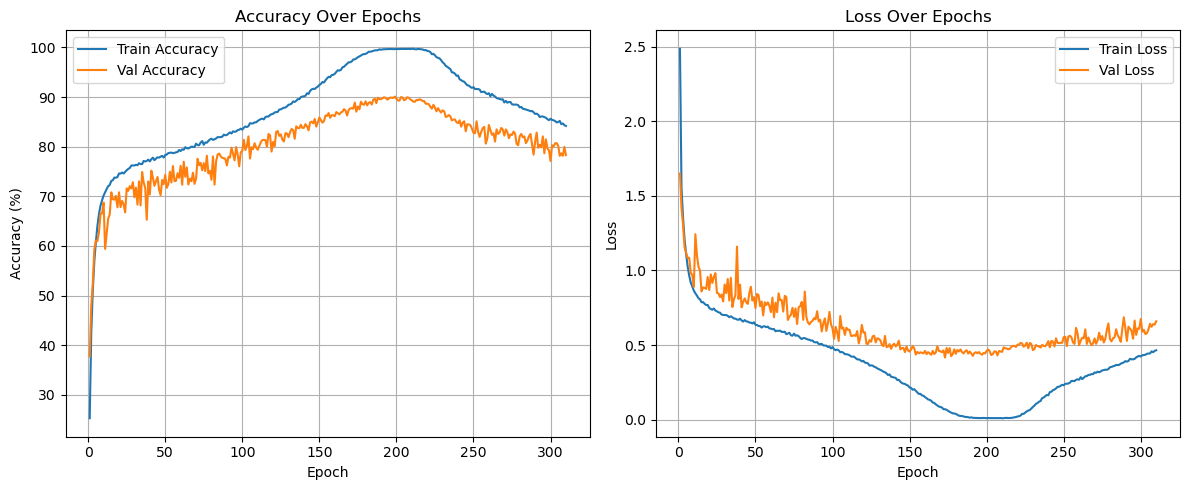


Best Val Accuracy: 89.56%
Final Test Accuracy: 79.27%


In [ ]:
# === Plotting ===
epochs = np.arange(1, 310 + 1)
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

print(f"\nBest Val Accuracy: {best_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

## load model

In [ ]:
loaded_state_dict = torch.load("best_resnet50_cifar10.pth");

/tmp/ipykernel_1989400/2922128743.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load("best_resnet50_cifar10.pth");


In [ ]:
loaded_vae = timm.create_model("resnet50", pretrained=False, num_classes=10)

In [ ]:
loaded_vae.load_state_dict(loaded_state_dict)
loaded_vae.to(device);

In [ ]:
def evaluate(net, dataloader, name="Val"):
    net.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / total
    acc = 100. * correct / total

    print(f"{name} Accuracy: {acc:.2f}%, Loss: {avg_loss:.4f}")
    return acc

evaluate(loaded_vae, testloader, name="Test")

Test Accuracy: 89.93%, Loss: 0.4312


89.93